In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

## General libraries
import seaborn as sns
from itertools import chain
import pydicom
from random import sample 

## Scikit-Learn
from skimage.io import imread, imshow
from skimage import io
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, auc, roc_auc_score, roc_curve, accuracy_score, precision_recall_curve, average_precision_score

## Keras 
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model, model_from_json
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import BatchNormalization

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:

## Loading the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
99502,00026337_007.png,No Finding,7,26337,57,M,AP,3056,2544,0.139,0.139,NaN,/data/images_011/images/00026337_007.png
44119,00011371_006.png,No Finding,6,11371,55,F,PA,2658,2765,0.143,0.143,NaN,/data/images_005/images/00011371_006.png
102908,00027431_000.png,Infiltration,0,27431,40,F,PA,2992,2991,0.143,0.143,NaN,/data/images_011/images/00027431_000.png


In [3]:
##Creating extra columns in the table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

all_labels = list(set(list(chain.from_iterable([i.split('|') for i in all_xray_df['Finding Labels']]))))
for c_label in all_labels:
    all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Pleural_Thickening,Cardiomegaly,Consolidation,Infiltration,Atelectasis,Pneumothorax,No Finding,Nodule,Pneumonia,Emphysema
39976,00010447_006.png,No Finding,6,10447,62,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
63830,00015754_016.png,No Finding,16,15754,34,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
51649,00013042_003.png,Infiltration,3,13042,69,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
all_xray_df.drop(columns=['Unnamed: 11'], inplace=True)

In [5]:
idx = all_xray_df[all_xray_df['Patient Age'] > 100].index.tolist()
all_xray_df.drop(index=idx, inplace=True)

In [6]:
# Checking number of Pneumonia cases
sum(all_xray_df['Pneumonia'] == 1)

1430

In [7]:
all_xray_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Pleural_Thickening,Cardiomegaly,Consolidation,Infiltration,Atelectasis,Pneumothorax,No Finding,Nodule,Pneumonia,Emphysema
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Data Preprocessing - Reference EDA notebook
Create column for every disease
Remove Unnamed: 11 column
Remove Patient Age outlier data for ages above 100. Mostly these are ages 150-413 which don't make sense and obviously data entry error
Remove images for Mass and Infiltration based on the Analysis in EDA notebook showing similarity in Pixel Density Distribution with Pneumonia cases.

In [8]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
all_xray_df['pneumonia_class'] = all_xray_df.apply(lambda x: 'Pneumonia' if x['Pneumonia'] == 1.0 else 'No Pneumonia', axis=1)
all_xray_df.head(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Cardiomegaly,Consolidation,Infiltration,Atelectasis,Pneumothorax,No Finding,Nodule,Pneumonia,Emphysema,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Pneumonia
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No Pneumonia
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Pneumonia


In [9]:
all_xray_df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'path', 'Mass',
       'Hernia', 'Effusion', 'Edema', 'Fibrosis', 'Pleural_Thickening',
       'Cardiomegaly', 'Consolidation', 'Infiltration', 'Atelectasis',
       'Pneumothorax', 'No Finding', 'Nodule', 'Pneumonia', 'Emphysema',
       'pneumonia_class'],
      dtype='object')

## Creating training and testing data:

In [10]:
def create_splits(df):
    
   
    train_df, val_df = train_test_split(df, test_size = 0.2, stratify = all_xray_df['Pneumonia'])
    
    np_count = train_df[train_df['Pneumonia'] == 0].index.tolist()
    p_count = train_df[train_df['Pneumonia'] == 1].index.tolist()
    
    np_sample = sample(np_count, len(p_count))
    
    train_df = train_df.loc[np_sample + p_count]
    
    np_count = val_df[val_df['Pneumonia'] == 0].index.tolist()
    p_count = val_df[val_df['Pneumonia'] == 1].index.tolist()
    
    np_sample = sample(np_count, 4 * len(p_count))
    
    val_df = val_df.loc[np_sample + p_count]

    
    return train_df, val_df

In [11]:
train_df, val_df = create_splits(all_xray_df)
print(f'Train set size: {len(train_df)}, valid set size: {len(val_df)}')

Train set size: 2288, valid set size: 1430


In [12]:
train_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Cardiomegaly,Consolidation,Infiltration,Atelectasis,Pneumothorax,No Finding,Nodule,Pneumonia,Emphysema,pneumonia_class
103956,00027726_054.png,Atelectasis|Infiltration,54,27726,58,M,AP,3056,2544,0.139,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,No Pneumonia
75267,00018465_001.png,No Finding,1,18465,62,M,PA,2654,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,No Pneumonia
14655,00003812_002.png,No Finding,2,3812,58,F,PA,2382,2361,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,No Pneumonia
53203,00013433_000.png,Infiltration,0,13433,27,M,AP,2500,2048,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,No Pneumonia
92508,00023091_012.png,No Finding,12,23091,66,F,PA,2550,2465,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,No Pneumonia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54289,00013641_004.png,Edema|Pneumonia,4,13641,39,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia
111767,00030621_002.png,Pneumonia,2,30621,22,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia
78166,00019176_076.png,Pneumonia,76,19176,66,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia
67571,00016704_000.png,Atelectasis|Pneumonia,0,16704,52,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,Pneumonia


# Model-building & training

In order to avoid overfitting problem and address the imbalanced Pneumonia cases in the dataset, extra Pneumonia scans should be added. This can be done by altering the training data with small transformations to reproduce the variations. Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

We can try the following approaches- 
1. Rotate some training images by 20-30 degrees
2. Zoom images by 15%-25% 
3. Shift images horizontally 
4. Shift images vertically 
5. Flip images horizontally

This can be done by setting the following values in the Image Data Generator function- 
1. horizontal_flip and vertical_flip should be set to True/False
2. height_shift_range and width_shift_range should be between 0 and 1
3. rotation_range can be between 0 and 180
4. shear_range can be between 0 and 1
5. zoom_range can be between 0 and 1

Image Generator can also be used to transform the values in each batch so that their mean is 0 and their standard deviation is 1 (this will standardize the input image distributions). The generator also converts single channel X-ray images (gray-scale) to a three-channel format by repeating the values in the image across all channels (this is required as pre-trained model that we'll use requires three-channel inputs).

You can choose an image size to resize your images to during augmentation, which comes in handy later when you want to do deep learning using a pre-trained CNN that has a specified size input layer
The input to cov1 layer of DenseNet, VGG16 and ResNet is of fixed size 224 x 224 RGB image.


In [13]:
IMG_SIZE = (512, 512)

In [14]:


def my_image_augmentation(train = True):
    
    if train == True:
        my_idg = ImageDataGenerator(rescale = 1 / 255.,
        horizontal_flip=True,
        vertical_flip=False,
        height_shift_range=0.1,
        width_shift_range=0.1,
        rotation_range=15,
        shear_range=0.1,
        zoom_range=0.15)
    else:
        my_idg = ImageDataGenerator(rescale = 1 / 255.)

    return my_idg


def make_train_gen(train_df):
    
    my_train_idg = my_image_augmentation(train = True)

    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
    directory=None, 
    x_col = 'path',
    y_col = 'pneumonia_class',
    class_mode = 'binary',
    target_size = IMG_SIZE, 
    batch_size = 32)

    return train_gen


def make_val_gen(val_df):
    
    my_val_idg = my_image_augmentation(train = False)

    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_df, 
    x_col = 'path',
    y_col = 'pneumonia_class',
    class_mode = 'binary',
    target_size = IMG_SIZE, 
    batch_size = 64) 

    return val_gen

In [15]:
train_gen = make_train_gen(train_df)
val_gen = make_val_gen(val_df)

Found 2288 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [16]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

In [17]:
train_gen.class_indices

{'No Pneumonia': 0, 'Pneumonia': 1}

In [18]:
val_gen.class_indices

{'No Pneumonia': 0, 'Pneumonia': 1}

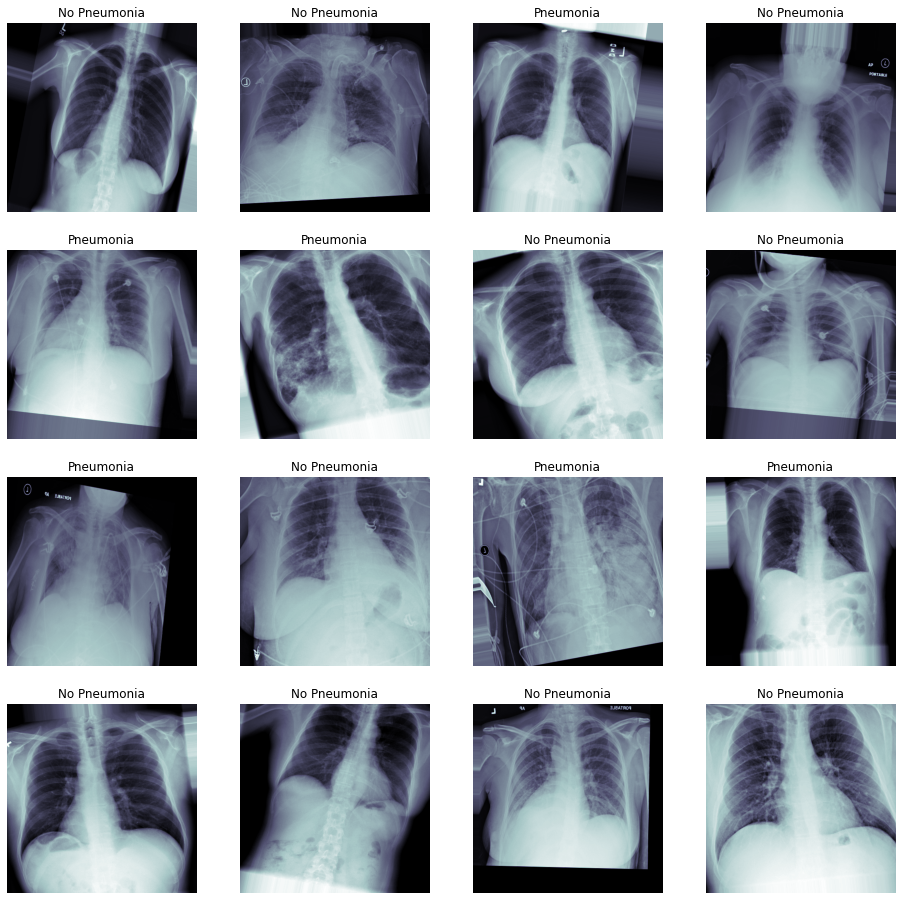

In [19]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

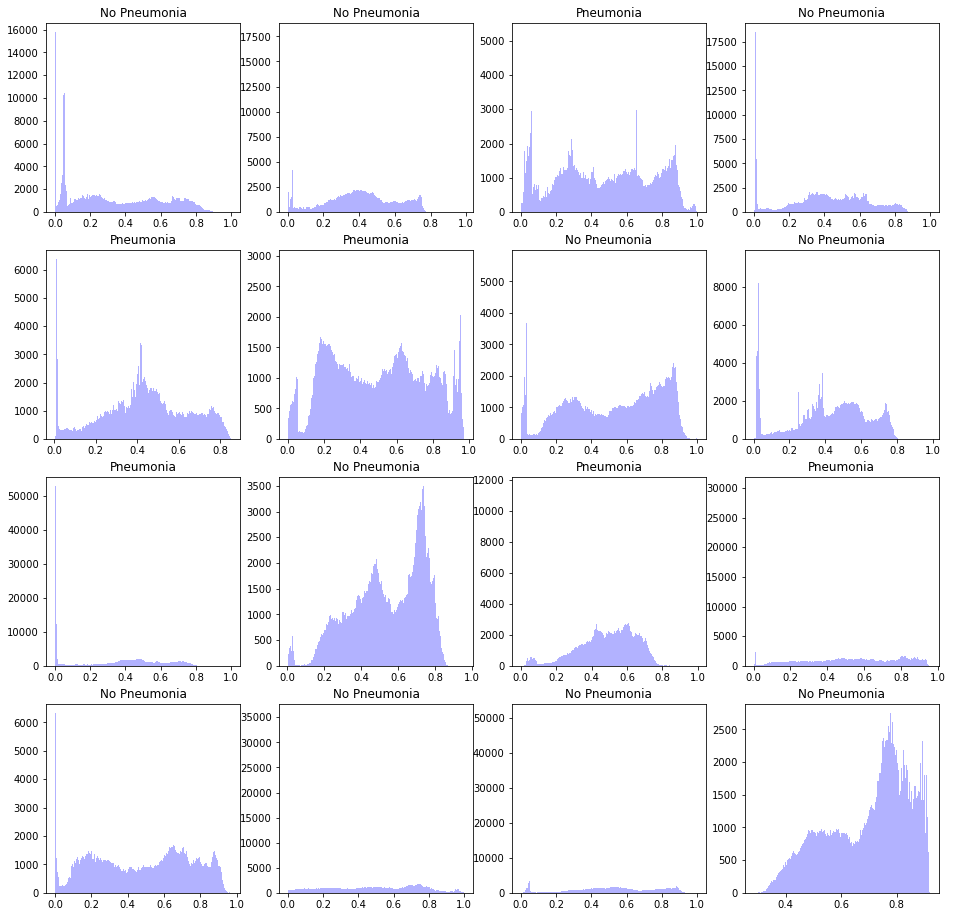

In [20]:
#Seeing intensity distribution of pixels after data augmentation
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
#     mask = (data > 0.1) & (data < 0.9)
#     d = data[mask].flatten()
    c_ax.hist(c_x[:,:,0].flatten(), bins = 256, alpha=0.3, color='blue')
    
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')

plt.show()

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [21]:
# from keras.applications import ResNet50
# #Matching input shape of ResNet to the target size of our augmented images
# #
# resnet_base_model = ResNet50(input_shape=(224,224,3), include_top=False, weights='imagenet')


In [21]:
def load_pretrained_model():
    model = VGG16(include_top=False, weights='imagenet',input_shape = (512, 512, 3))
    
    return model



In [22]:
model = VGG16(include_top=False, weights='imagenet',input_shape = (512, 512, 3))
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0     

In [23]:
# !pip install keract

In [24]:
# from keras import activations
# import keract
# from keract import display_heatmaps, display_activations
# activations = get_activations(model, x)

In [25]:
# from keras.layers import *
# from keras.models import Sequential
# from keras.applications.resnet50 import ResNet50

In [27]:
##I have kept the first 15 layers as frozen and decided to unfreeze the last block so 
    #that their weights get updated in each epoch
# Freeze four convolution blocks
for layer in model.layers[:15]:
    layer.trainable = False
# Make sure you have frozen the correct layers
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

#so we will be training our dataset on the last four layers of the pre-trained VGG-16 model

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [28]:
def build_my_model():
    vgg_base_model = load_pretrained_model()
    #I have kept the first 15 layers as frozen and decided to unfreeze the last block so 
    #that their weights get updated in each epoch

    for layer in vgg_base_model.layers[:15]:
        layer.trainable = False
        
    vgg16_model = Sequential()
    vgg16_model.add(vgg_base_model)
    # Flatten the output of the VGG16 model because it is from a convolutional layer.
    vgg16_model.add(GlobalAveragePooling2D(),)
    vgg16_model.add(Dense(256, activation="relu"))
    BatchNormalization()
    vgg16_model.add(Dropout(0.4))
    vgg16_model.add(Dense(128, activation="relu"))
    BatchNormalization(),
    vgg16_model.add(Dropout(0.3))
    vgg16_model.add(Dense(64,activation="relu"))
    BatchNormalization()
    vgg16_model.add(Dense(32,activation="relu"))
    BatchNormalization()
    vgg16_model.add(Dropout(0.3))
    vgg16_model.add(Dense(1,activation="sigmoid"))

    
    return vgg16_model


In [29]:
vgg_build_model = build_my_model()
vgg_build_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 16, 16, 512)       14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)               

In [30]:
import tensorflow as tf
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
METRICS = [
    'accuracy',
    'binary_accuracy',
    'binary_crossentropy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
vgg_build_model.compile(optimizer=opt,loss='binary_crossentropy',metrics=METRICS)

In [31]:
## Sample code to add another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results- can be done by using get_activations in the keract library
# golden = build_my_model().output[:, np.argmax(preds[0])]
# last_conv_layer = model.get_layer('activation_49')
# from keras import backend as K
# grads = K.gradients(golden, last_conv_layer.output)[0]
# pooled_grads = K.mean(grads, axis=(0, 1, 2))
# iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
# pooled_grads_value, conv_layer_output_value = iterate([x])
# for i in range(pooled_grads.shape[0]):
#     conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
# heatmap = np.mean(conv_layer_output_value, axis=-1)
# import matplotlib.pyplot as plt
# heatmap = np.maximum(heatmap, 0)
# heatmap /= np.max(heatmap)
# plt.matshow(heatmap)

In [32]:


weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [33]:
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(train_gen),
#                                                 train_gen)

In [34]:

# # Class weights

# weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
# weight_for_1 = num_normal / (num_normal + num_pneumonia)

# class_weight = {0: weight_for_0, 1: weight_for_1}

In [35]:
## Training Model

r = vgg_build_model.fit_generator(train_gen,
          epochs=20,
          validation_data=(valX, valY),
          steps_per_epoch=100,
          validation_steps=25,
        callbacks = callbacks_list)

Epoch 1/20
100/100 [==============================] - 251s 3s/step - loss: 0.7060 - accuracy: 0.5126 - binary_accuracy: 0.5126 - binary_crossentropy: 0.7060 - precision: 0.5262 - recall: 0.4335 - val_loss: 0.6907 - val_accuracy: 0.8281 - val_binary_accuracy: 0.8281 - val_binary_crossentropy: 0.6907 - val_precision: 0.5074 - val_recall: 0.4567

Epoch 00001: val_loss improved from inf to 0.69066, saving model to xray_class_my_model.best.hdf5
Epoch 2/20
100/100 [==============================] - 242s 2s/step - loss: 0.6953 - accuracy: 0.4896 - binary_accuracy: 0.4896 - binary_crossentropy: 0.6953 - precision: 0.5052 - recall: 0.4482 - val_loss: 0.6925 - val_accuracy: 0.8281 - val_binary_accuracy: 0.8281 - val_binary_crossentropy: 0.6925 - val_precision: 0.5027 - val_recall: 0.4908

Epoch 00002: val_loss did not improve from 0.69066
Epoch 3/20
100/100 [==============================] - 239s 2s/step - loss: 0.6952 - accuracy: 0.5009 - binary_accuracy: 0.5009 - binary_crossentropy: 0.6951 - 

In [37]:

vgg_build_model.load_weights(weight_path)
pred_Y = vgg_build_model.predict(valX, batch_size = 32, verbose = True)

64/64 [==============================] - 3s 54ms/step


In [38]:
def plot_roc_curve(ground_truth, probability):
    fpr, tpr, _ = roc_curve(ground_truth, probability)
    plt.figure(figsize = (12, 8))
    plt.style.use("ggplot")
    plt.plot(fpr, tpr, label = f"Pneumonia AUC Score: {auc(fpr, tpr)}")
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC-Curve')
    plt.legend()



def plot_precision_recall_curve(gt, prob):
    
    precision, recall, threshold = precision_recall_curve(gt, prob)
    
    plt.figure(figsize = (12, 8))
    plt.style.use("ggplot")
    plt.plot(recall, precision, label =  f"Pneumonia AP Score: {average_precision_score(gt, prob)}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR-Curve')
    plt.legend()
    
def f1_score(p, r):
    if(p == 0 or r == 0):
        return 0
    return 2 * p * r / (p + r)

#plotting the history of model training:

def plot_history(history):
    
    fig, axs = plt.subplots(1, 2, figsize = (12, 5))
    axs = axs.flatten()
    plt.style.use("ggplot")
    N = len(history.history["loss"])
    
    axs[0].plot(np.arange(N), history.history["loss"], label = 'train_loss')
    axs[0].plot(np.arange(N), history.history["val_loss"], label = 'val_loss')
    axs[0].set_xlabel('# epochs')
    axs[0].set_ylabel('loss')
    axs[0].set_title('Loss curve')
    axs[0].legend()
    
    axs[1].plot(np.arange(N), history.history["binary_accuracy"], label = 'train_binary_accuracy')
    axs[1].plot(np.arange(N), history.history["val_binary_accuracy"], label = 'val_binary_accuracy')
    axs[1].set_xlabel('# epochs')
    axs[1].set_ylabel('accuracy')
    axs[1].set_title('Accuracy curve')
    axs[1].legend()
    
    return

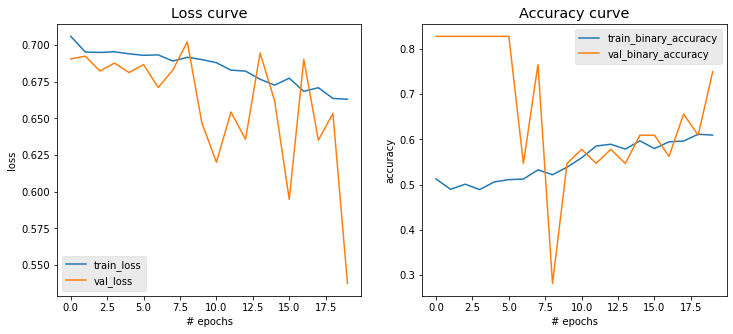

In [39]:
plot_history(r)

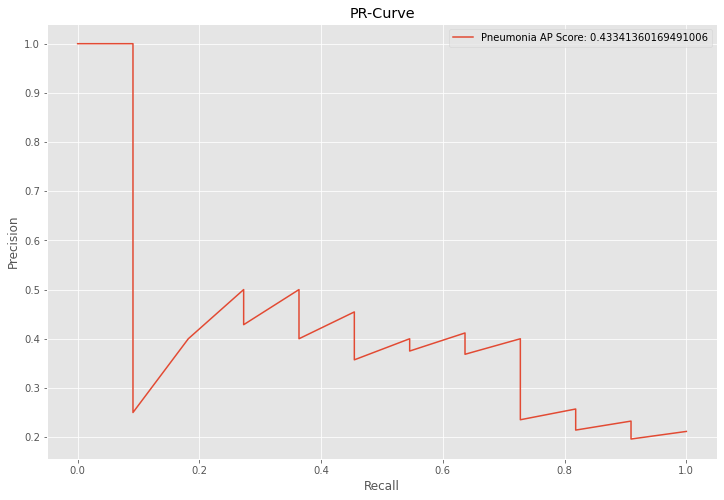

In [40]:
plot_precision_recall_curve(valY, pred_Y)

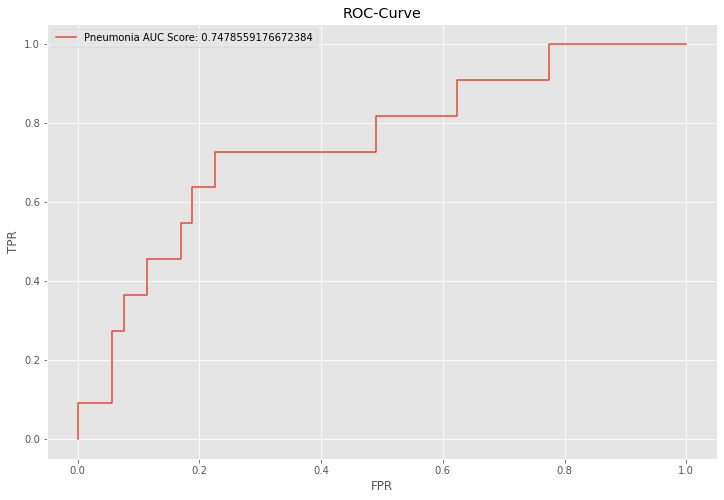

In [41]:

plot_roc_curve(valY, pred_Y)

In [42]:
precision, recall, threshold = precision_recall_curve(valY, pred_Y.ravel())
f1_scores = [f1_score(precision[i], recall[i]) for i in range(len(threshold))]

Text(0.5, 1.0, 'F1-score on different thresholds')

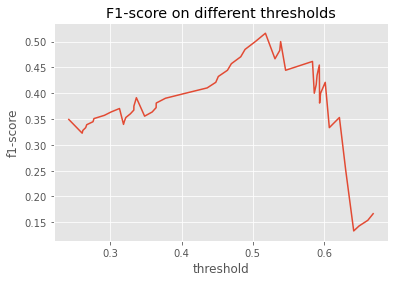

In [43]:
plt.figure()
plt.style.use("ggplot")
plt.plot(threshold, f1_scores)
plt.xlabel('threshold')
plt.ylabel('f1-score')
plt.title('F1-score on different thresholds')

In [44]:
thresh_idx = np.argmax(f1_scores)
thresh = threshold[thresh_idx]
print(f"Precision at {thresh} threshold is {precision[thresh_idx]}.")
print(f"Recall at {thresh} threshold is {recall[thresh_idx]}.")
print(f"F1 score at {thresh} threshold is {f1_scores[thresh_idx]}.")

Precision at 0.5177772641181946 threshold is 0.4.
Recall at 0.5177772641181946 threshold is 0.7272727272727273.
F1 score at 0.5177772641181946 threshold is 0.5161290322580645.


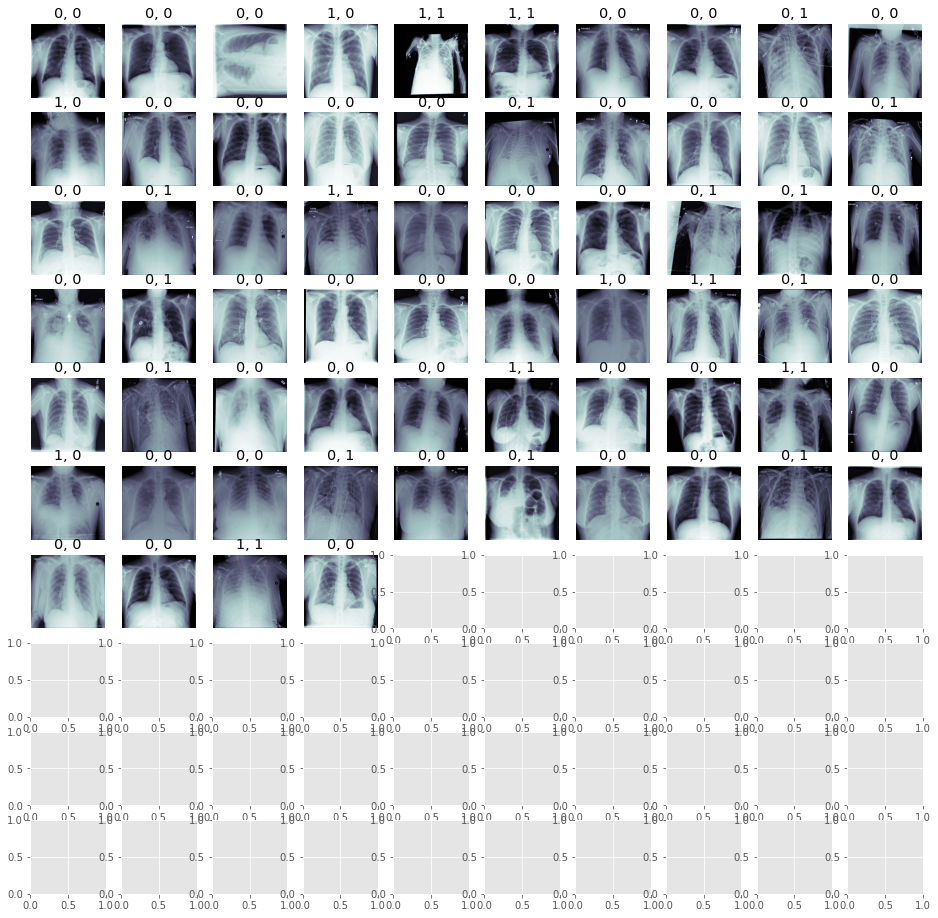

In [45]:
## Examples of true vs. predicted with our best model: 


fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > thresh:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > thresh: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [47]:
## Saving model architecture to a .json:

model_json = vgg_build_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)